<a href="https://colab.research.google.com/github/antoinexp/Ph.D/blob/master/McKean_Vlasov_centered_isotropic_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
from IPython.display import display
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_probability as tfp
import itertools
import seaborn as sns
import scipy.integrate as integrate
from scipy.special import gamma

In [ ]:
class Initializer:
  class normal:
    def __call__(self, shape): return tf.random.normal(shape)

  class spherical:
    def __call__(self, shape):
      X = tf.random.normal(shape)
      return tf.math.l2_normalize(X, axis=1)

In [ ]:
Bernoulli = tfp.distributions.Bernoulli(probs=0.5, dtype="float32")

In [ ]:
class ModelCGI(object):
  def __init__(self, N, n, d, delta=0.1, n_test=None, 
               _lambda_a=1., 
               _lambda_theta=1., 
               _lambda_reg=0.1,
               _beta_a=1., 
               _beta_theta=1.,
               activation="linear"):
    self._lambda_a = _lambda_a
    self._lambda_theta = _lambda_theta
    self._beta_a = _beta_a
    self._beta_theta = _beta_theta
    if type(activation) == str:
      self.activation = tf.keras.layers.Activation(activation).activation
    else:
      self.activation = activation
    self._lambda_reg = _lambda_reg

    self._N = N
    self._n = n
    self._d = d

    self._a = tf.Variable((1/self._N)*tf.ones((self._N,)))
    #self._a = tf.Variable((1/self._N**0.5)*tf.random.normal((1,self._N))[0])
    self._theta = tf.Variable( (0.8/d**0.5)*tf.random.normal((self._N,d)) )
    #self._a = tf.Variable((1/self._N)*tf.random.uniform((1,self._N), -(3.)**0.5, (3.)**0.5)[0])
    #self._theta = tf.Variable(tf.random.uniform((self._N,d), -(3.)**0.5, (3.)**0.5))

    self.Y_train = 2*Bernoulli.sample((n,)) - 1
    self.xi = tf.random.normal((n,d))
    self.X_train = tf.reshape((tf.ones(n)+self.Y_train*delta), (-1,1))*self.xi
    
    if not n_test: n_test = n
    self._n_test = n_test

    self.Y_test = 2*Bernoulli.sample((n_test,))-1
    self.xi = tf.random.normal((n_test,d))
    self.X_test = tf.reshape((tf.ones(n_test)+self.Y_test*delta), (-1,1))*self.xi


  @tf.function
  def __call__(self, X):
    d = X.shape[1]
    W = tf.tensordot(X, tf.transpose(self._theta), 1)
    Z = self.activation(W)
    return tf.tensordot(Z, self._a, 1)

  @tf.function
  def R(self, X, Y, n=None):
    error = Y - self(X)
    if not n: n = self._n
    reg = (self._N/self._d)*self._lambda_reg*(tf.norm(self._a)**2.)
    return (1./n)*tf.norm(error)**2. + reg

  def R_train(self):
    return self.R(self.X_train, self.Y_train, n=self._n)

  def R_test(self):
    return self.R(self.X_test, self.Y_test, n=self._n_test)


  @tf.function
  def learn(self, dt=0.1):
    R = self.R(self.X_train, self.Y_train)
    grad_a = tf.gradients(R, self._a)[0]
    grad_theta = tf.gradients(R, self._theta)[0]

    dW_a = tf.random.normal((self._N,))
    dW_theta = tf.random.normal((self._N,self._d))

    d_a = ((-1./self._lambda_a)*grad_a*dt + 
      ((2./(self._lambda_a*self._beta_a))**0.5)*(dt**0.5)*dW_a)
    d_theta = ((-1./self._lambda_theta)*grad_theta*dt + 
        ((2./(self._lambda_theta*self._beta_theta))**0.5)*(dt**0.5)*dW_theta)

    self._a.assign_add(d_a)
    self._theta.assign_add(d_theta)

    return self.R_train()

  @tf.function
  def learn_steps(self, dt=0.1, steps=10):
    res = 0.
    for _ in tf.range(steps):
      res = self.learn(dt)
    return res

  def learn_epochs(self, dt=0.1, steps=10, epochs=10, callback=None):
    history = []
    for epoch in range(epochs):
      history.append({
          "epoch": epoch,
          "step": epoch*steps,
          "t": epoch*steps*dt,
          "mse_train": self.R_train().numpy(),
          "mse_test": self.R_test().numpy(),
      })
      if epoch<epochs-1:
        self.learn_steps(dt, steps)
    return pd.DataFrame(history).set_index("t")

In [ ]:
def activation(t):
  t1,t2 = 0.5, 1.5
  s1,s2 = -2.5, 7.5
  t0 = tf.math.minimum(tf.math.maximum(t, t1), t2)
  return (s2-s1)*(t0-t1)/(t2-t1) + s1

In [ ]:
config=dict(
    activation = activation
    ,
    _lambda_a=1e10 #@param {type:"number"}
    , 
    _lambda_theta=1 #@param {type:"number"}
    ,
    _beta_a=1e10 #@param {type:"number"}
    ,
    _beta_theta=1e10 #@param {type:"number"}
    , 
    _lambda_reg=0. #@param {type:"number"}
    ,

    N=800 #@param {type:"slider", min:0, max:4000, step:1}
    ,
    n=1000 #@param {type:"slider", min:0, max:4000, step:1}
    , 
    d=40 #@param {type:"slider", min:0, max:4000, step:1}
    ,
    n_test=1000 #@param {type:"slider", min:0, max:4000, step:1}
       
)

runtime_parameters=dict(
    dt = 1.0
    ,
    steps=100 #@param {type:"number"}
    ,
    epochs=150 #@param {type:"number"}
)

In [ ]:
model = ModelCGI(**config, delta=0.8)


In [ ]:
history = model.learn_epochs(**runtime_parameters)


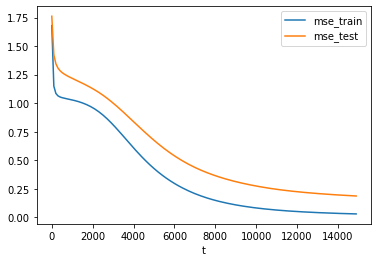

In [ ]:
history[["mse_train", "mse_test"]].plot()

In [ ]:
v = tf.norm(model._theta, axis=1).numpy()

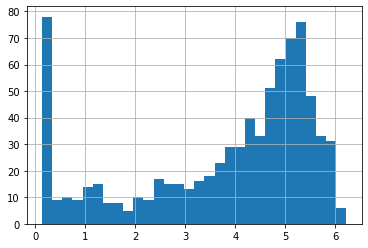

In [ ]:
plt.hist(v, bins=30)
plt.plot()
plt.grid()